In [10]:
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_background_variable import get_background_variable
from read_simulation_data.get_num_snaps import get_num_snaps
from read_simulation_data.get_info import get_info
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import os
import astropy.units as u

from plot_simulation_data.plot_foreground_variable_1D import plot_foreground_variable_1D
from plot_simulation_data.plot_all_foreground_variables_1D import plot_all_foreground_variables_1D
from plot_simulation_data.animate_all_foreground_variables_1D import animate_all_foreground_variables_1D

DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
R_SUN = 6.957e10

In [11]:
def central_z(var, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    
    central = (positive_var-negative_var)/(2*dz)
    # Set endpoints to zero
    central[0] = 0
    central[1] = 0
    central[2] = 0
    central[-3] = 0
    central[-2] = 0
    central[-1] = 0
    return central

def upwind_z(var, v, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    #calculating upwind scheme for positive velocity
    upwind = (var - negative_var)/dz

    #checking if velocity<0 at any point in the grid
    x = np.where(v<0)

    #checking if any negative values occured and using the upwind scheme for negative velocity
    #at the points of negative velocity values
    if len(x) != 0:
        for index in range(len(x)):
            x_index = x[index]
            upwind[x_index] = (positive_var[x_index] - var[x_index])/dz

    # Set endpoints to zero
    upwind[0] = 0
    upwind[1] = 0
    upwind[2] = 0
    upwind[-3] = 0
    upwind[-2] = 0
    upwind[-1] = 0
    return upwind

def central_second_z(var, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    #calculating central difference scheme for second derivative
    central_second = (positive_var-2*var+negative_var)/(dz**2)

    # Set endpoints to zero
    central_second[0] = 0
    central_second[1] = 0
    central_second[2] = 0
    central_second[-3] = 0
    central_second[-2] = 0
    central_second[-1] = 0
    return central_second

In [12]:
def dp1_dz(folder, snap_number):
    _, _, grid_info_dict = get_info(folder)
    dz = grid_info_dict['dz'][0]
    p1,_,t = get_foreground_variable(folder, snap_number, 'p1')
    return central_z(p1, dz), t

def dvz_dz_upwind(folder, snap_number):
    _, _, grid_info_dict = get_info(folder)
    dz = grid_info_dict['dz'][0]
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')
    return upwind_z(vz, vz, dz), t

def dvz_dz_central(folder, snap_number):
    _, _, grid_info_dict = get_info(folder)
    dz = grid_info_dict['dz'][0]
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')
    return central_z(vz, dz), t

In [13]:
def rhs_vz(folder, snap_number):
    _, _, grid_info_dict = get_info(folder)
    dz = grid_info_dict['dz'][0]

    p1,_,_ = get_foreground_variable(folder, snap_number, 'p1')
    rho1,_,_ = get_foreground_variable(folder, snap_number, 'rho1')
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')

    rho0,_ = get_background_variable(folder, 'rho0')
    g,_ = get_background_variable(folder, 'g')

    dp1_dz_,_ = dp1_dz(folder, snap_number)
    dvz_dz_,_ = dvz_dz_upwind(folder, snap_number)

    rhs = -1/rho0*(rho1*g + dp1_dz_) - vz*dvz_dz_

    return rhs, t

In [14]:
def plot_rhs_vz_1D(folder, ax, snap_number, key, **kwargs):
    rhs,t = rhs_vz(folder, snap_number)

    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$\partial_t v_z$ [cm/s$^2$]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, rhs)
    return im, t

In [15]:
def plot_dp1_dz_over_rho0(folder, ax, snap_number, key, **kwargs):
    dp1_dz_,t = dp1_dz(folder, snap_number)
    rho0,_ = get_background_variable(folder, 'rho0')

    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$\partial_z p_1/\\rho_0$ [cm-1 s-2]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, dp1_dz_/rho0)
    return im, t

In [16]:
def plot_rho1_g_over_rho0(folder, ax, snap_number, key, **kwargs):
    rho1,_,t = get_foreground_variable(folder, snap_number, 'rho1')
    g,_ = get_background_variable(folder, 'g')
    rho0,_ = get_background_variable(folder, 'rho0')

    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$\\rho_1 g/\\rho_0$ [cm s-2]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, rho1*g/rho0)
    return im, t

In [17]:
def plot_vz_dvz_dz_upwind(folder, ax, snap_number, key, **kwargs):
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')
    dvz_dz_, t = dvz_dz_upwind(folder, snap_number)

    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$v_z \partial_z v_z$ [cm s-2]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, vz*dvz_dz_)
    return im, t

In [18]:
def drho0_dz(folder, snap_number):
    _, _, grid_info_dict = get_info(folder)

    dz = grid_info_dict['dz'][0]
    rho0,_ = get_background_variable(folder, 'rho0')
    _,_,t = get_foreground_variable(folder, snap_number, 'rho1')
    return central_z(rho0, dz), t

def ddvz_dz_dz_central(folder, snap_number):
    _, _, grid_info_dict = get_info(folder)

    dz = grid_info_dict['dz'][0]
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')
    return central_second_z(vz, dz), t

In [19]:
def rhs_p1(folder, snap_number):

    drho0_dz_,_ = drho0_dz(folder, snap_number)
    dvz_dz_,_ = dvz_dz_central(folder, snap_number)
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')
    rho0,_ = get_background_variable(folder, 'rho0')
    ddvz_dzdz_,_ = ddvz_dz_dz_central(folder, snap_number)

    rhs = -drho0_dz_ * vz * dvz_dz_ - rho0 * (dvz_dz_**2 + vz*ddvz_dzdz_)

    return rhs, t

In [20]:
def plot_rhs_p1(folder, ax, snap_number, key, **kwargs):
    rhs,t = rhs_p1(folder, snap_number)
    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$\partial_z^2 p_1$ [dyn cm-4]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, rhs)
    return im, t

In [21]:
def plot_rho0_dvz_dz_sqrd(folder, ax, snap_number, key, **kwargs):
    rho0,_ = get_background_variable(folder, 'rho0')
    dvz_dz_,t = dvz_dz_central(folder, snap_number)
    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$\\rho_0 (\partial_z v_z)^2$ [dyn cm-4]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, rho0*(dvz_dz_**2))
    return im, t

In [22]:
def plot_rho0_vz_ddvz_dzdz(folder, ax, snap_number, key, **kwargs):
    rho0,_ = get_background_variable(folder, 'rho0')
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')
    ddvz_dzdz_,_ = ddvz_dz_dz_central(folder, snap_number)
    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$\\rho_0 v_z \partial_z^2 v_z$ [dyn cm-4]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, rho0*vz*ddvz_dzdz_)
    return im, t

In [23]:
def plot_vz_dvz_dz_drho0_dz(folder, ax, snap_number, key, **kwargs):
    rho0,_ = get_background_variable(folder, 'rho0')
    vz,_,t = get_foreground_variable(folder, snap_number, 'vz')
    dvz_dz_,_ = dvz_dz_central(folder, snap_number)
    drho0_dz_,_ = drho0_dz(folder, snap_number)
    r,_ = get_background_variable(folder, 'r')

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    ax.set_ylabel(f"$\partial_z\\rho_0 v_z \partial_z v_z$ [dyn cm-4]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, vz*dvz_dz_*drho0_dz_)
    return im, t

In [24]:
def plot_drho1g_dz(folder, ax, snap_number, key, **kwargs):
    _, _, grid_info_dict = get_info(folder)
    dz = grid_info_dict['dz'][0]
    rho1,_,t = get_foreground_variable(folder, snap_number, 'rho1')
    g,_ = get_background_variable(folder, 'g')
    r,_ = get_background_variable(folder, 'r')

    drho1g_dz = central_z(rho1*g, dz)

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")
    if kwargs.get('grid_on') == None:
        ax.grid(True)
    else:
        ax.grid(kwargs.get('grid_on'))
    
    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))

    ax.set_ylabel(f"$\\partial_z (\\rho_1 g)$ [dyn cm-4]", fontsize=font_size)
    ax.set_xlabel("z [Solar radii]", fontsize=font_size)

    im = plt.plot(r/R_SUN, drho1g_dz)
    return im, t

In [5]:
from visualize_background import plot_background

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


/net/hume.uio.no/uio/hume/student-u58/tabjone/anelastic_mhd_solver/visualisation/visualize_background.py:38: RuntimeWarning: invalid value encountered in divide
  solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_sun)**2)


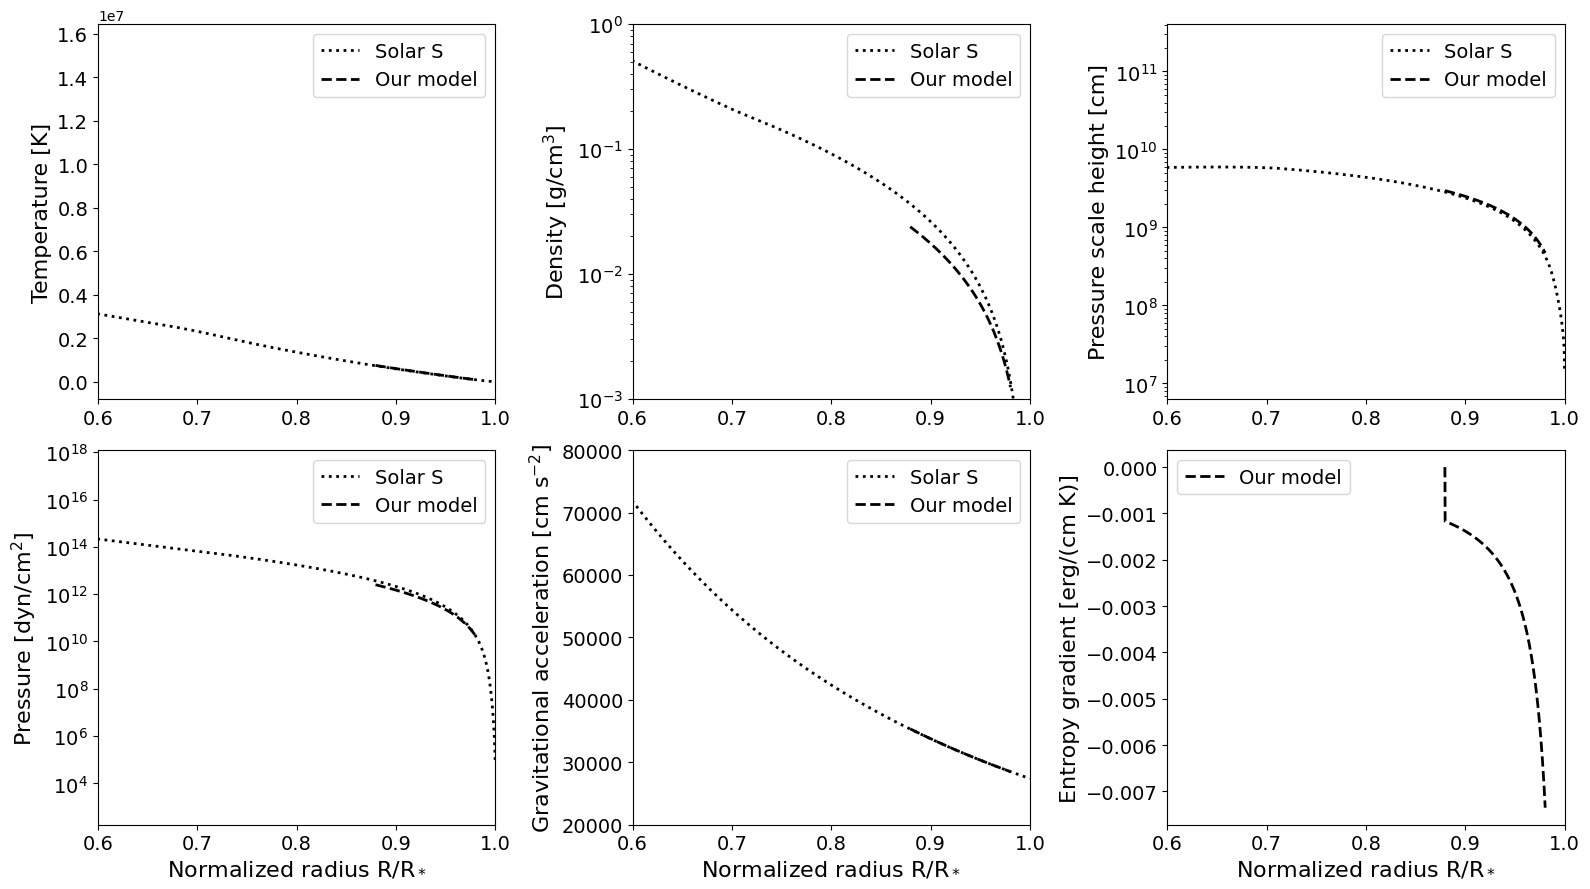

In [29]:
1000/25

40.0

/net/hume.uio.no/uio/hume/student-u58/tabjone/anelastic_mhd_solver/visualisation/visualize_background.py:38: RuntimeWarning: invalid value encountered in divide
  solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_sun)**2)
/net/hume.uio.no/uio/hume/student-u58/tabjone/anelastic_mhd_solver/visualisation/visualize_background.py:40: RuntimeWarning: divide by zero encountered in divide
  var['H'] = var['p0']/(var['rho0']*var['g'])


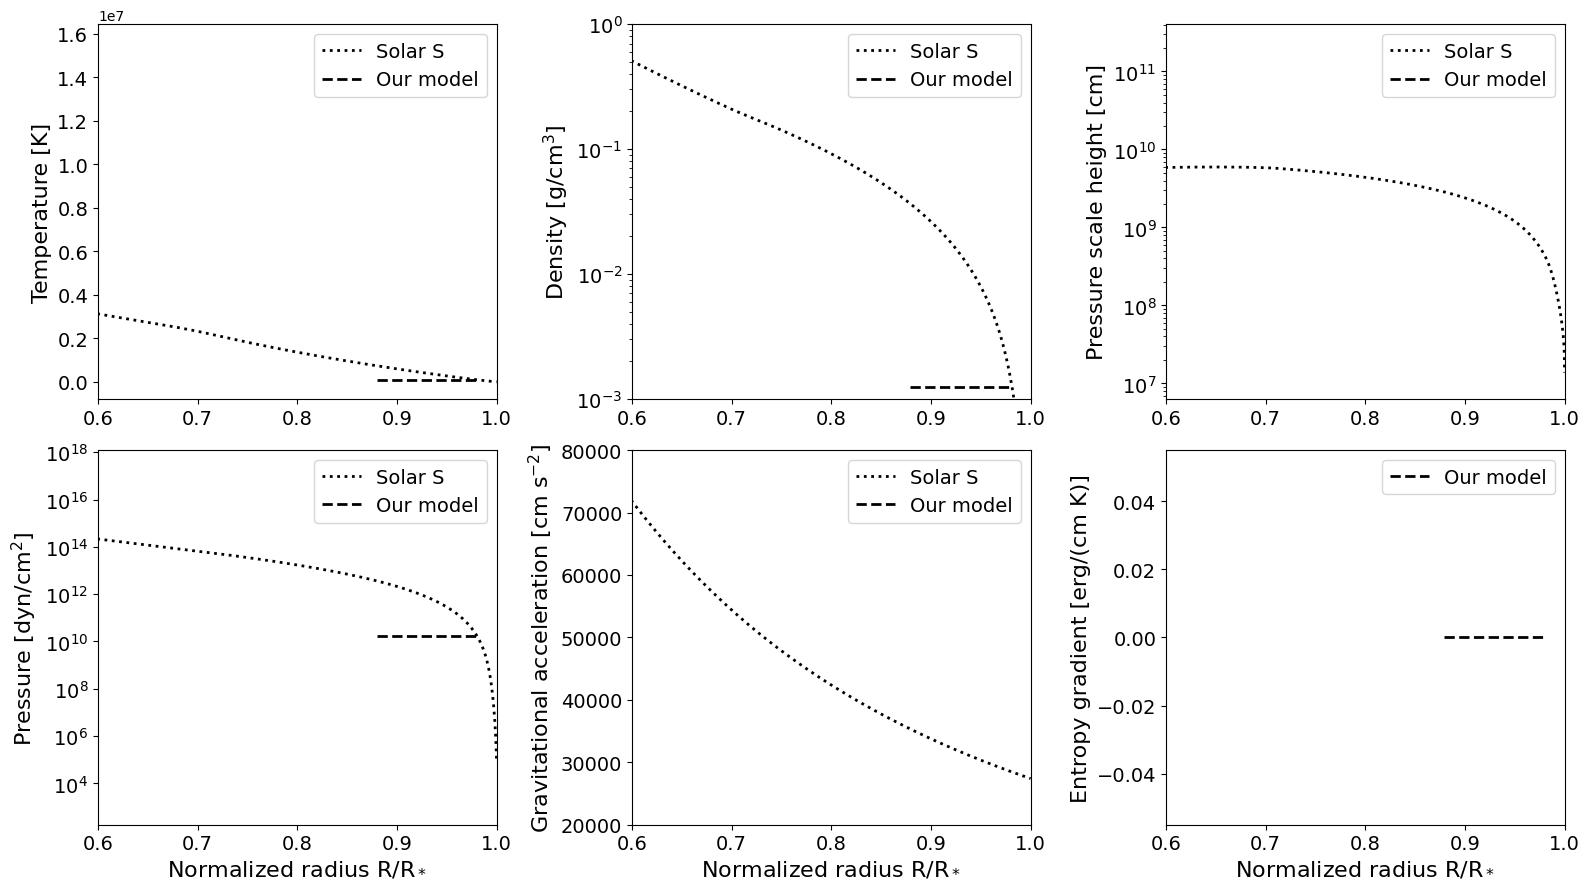

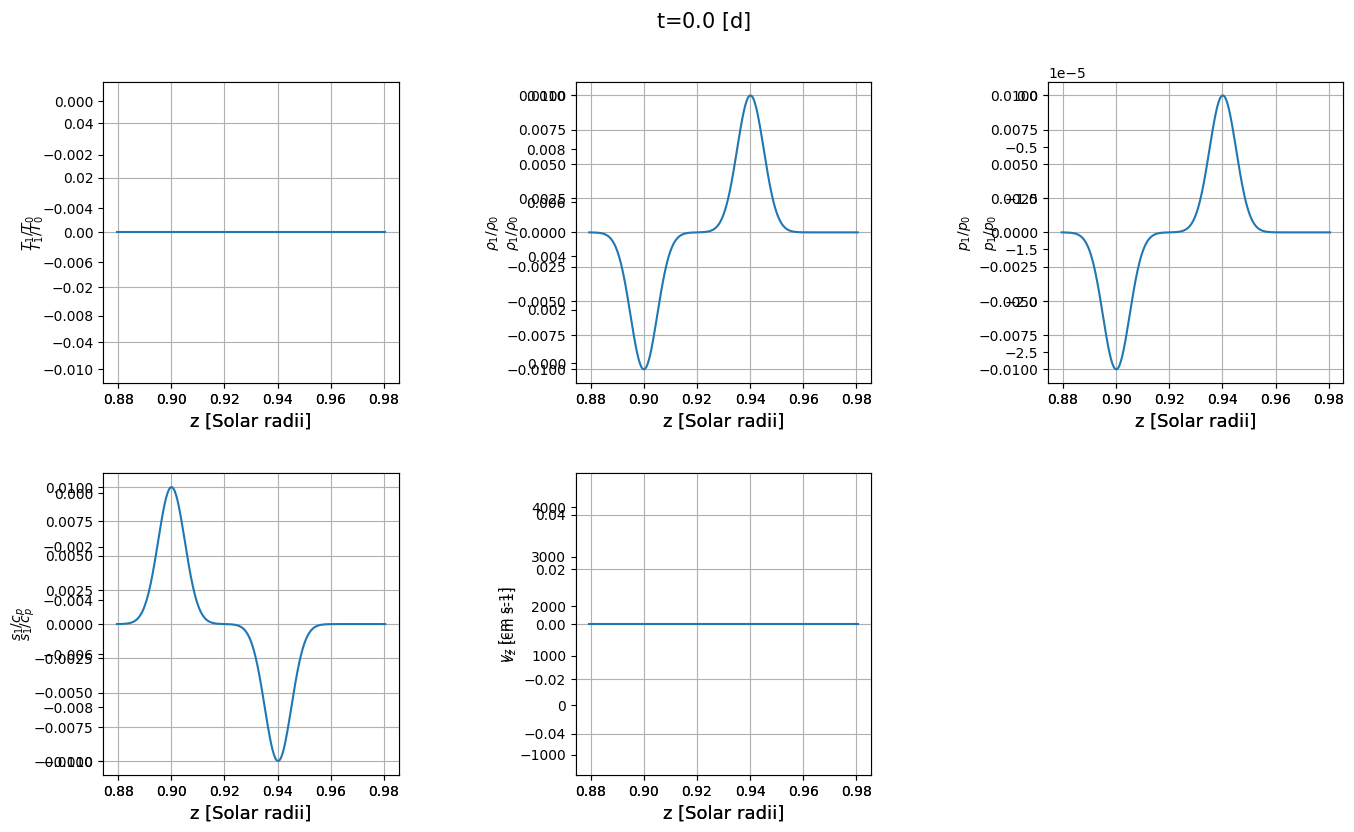

In [31]:
RUN_NAME = "const_bg_3/"
SAVE_FOLDER = 'data/'

if not os.path.exists(SAVE_FOLDER+RUN_NAME):
    os.makedirs(SAVE_FOLDER+RUN_NAME)


plot_background(DATA_FOLDER,RUN_NAME, SAVE_FOLDER+RUN_NAME+"background.png")

animate_all_foreground_variables_1D(DATA_FOLDER+RUN_NAME, save=True, save_name=SAVE_FOLDER+RUN_NAME+"foreground.mp4", fps=25, save_interval=1, **{'normalize':True, 't_scale':u.day})

/net/hume.uio.no/uio/hume/student-u58/tabjone/anelastic_mhd_solver/visualisation/visualize_background.py:38: RuntimeWarning: invalid value encountered in divide
  solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_sun)**2)


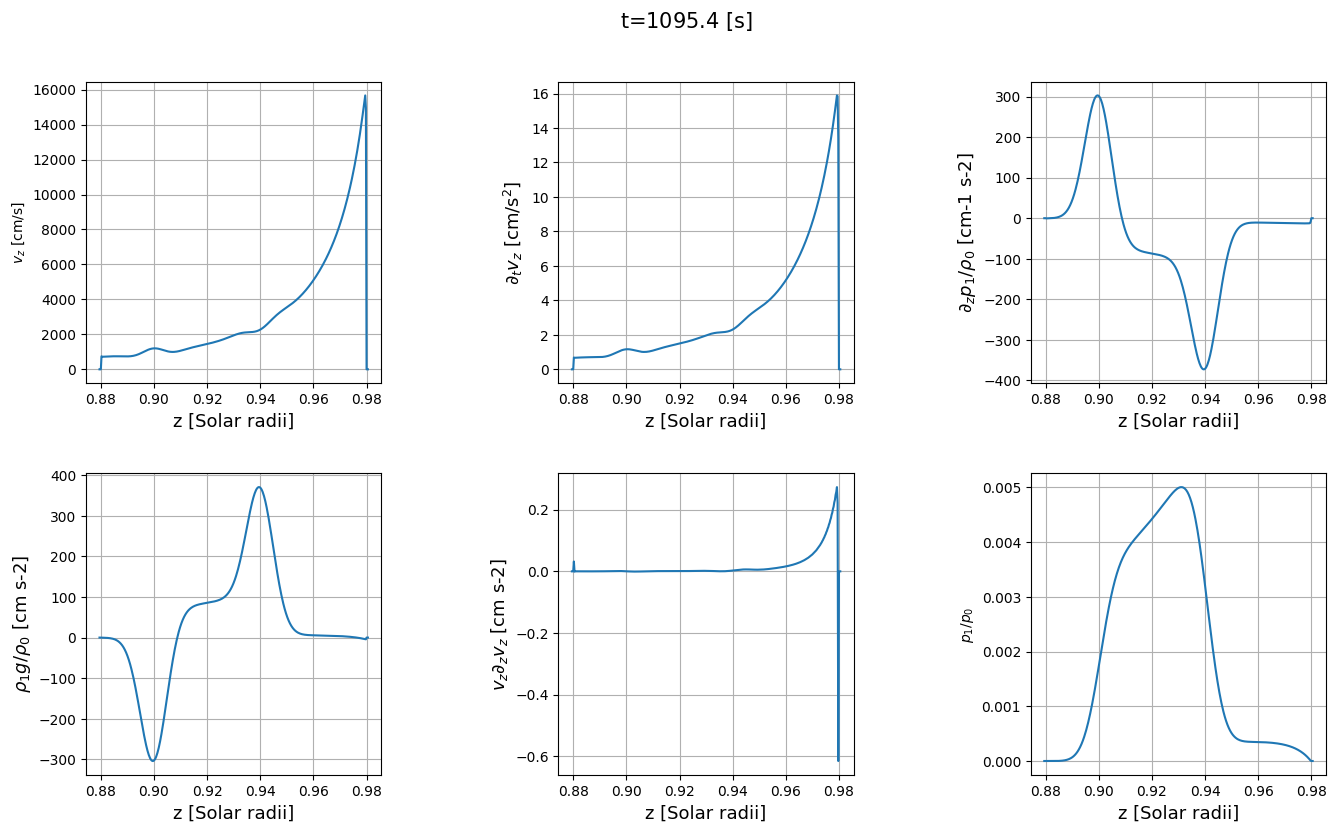

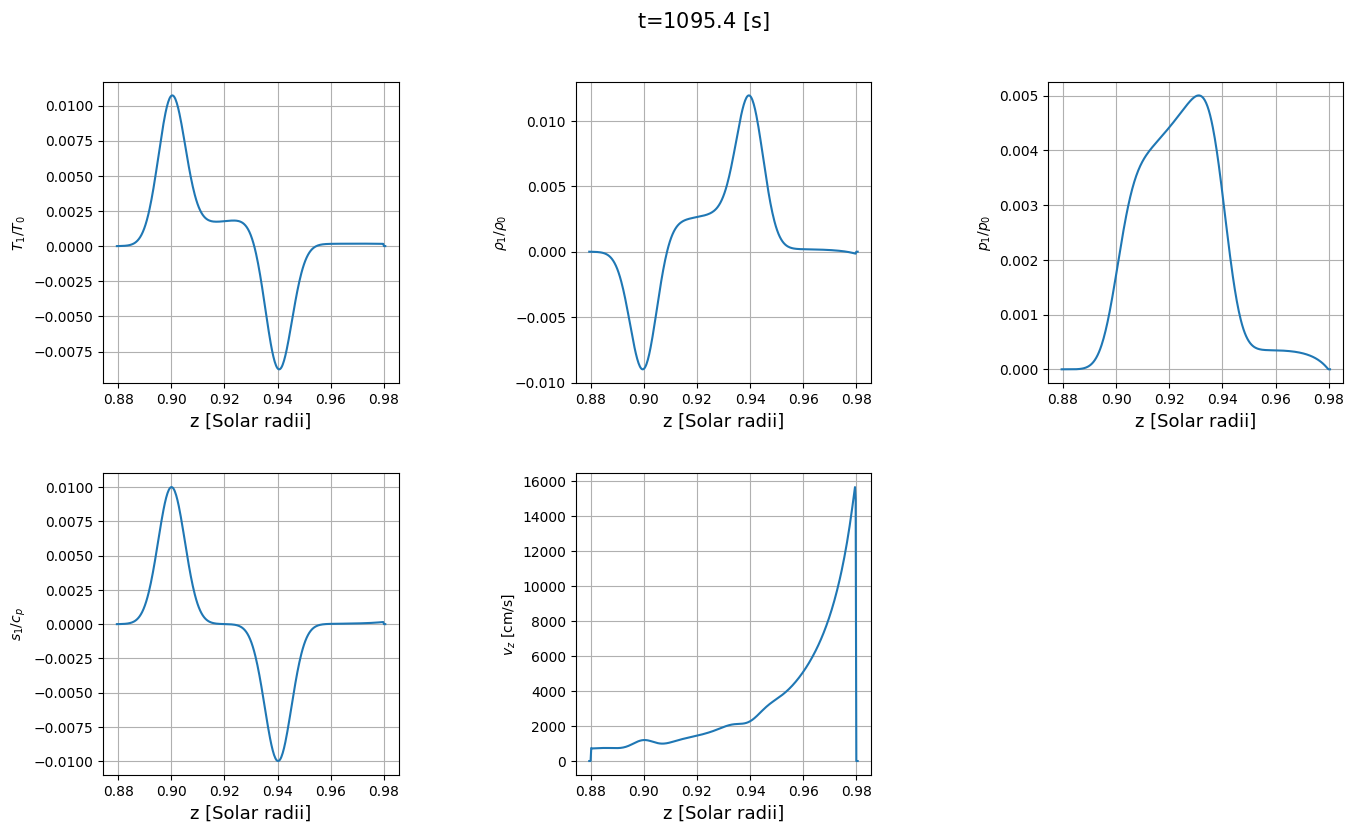

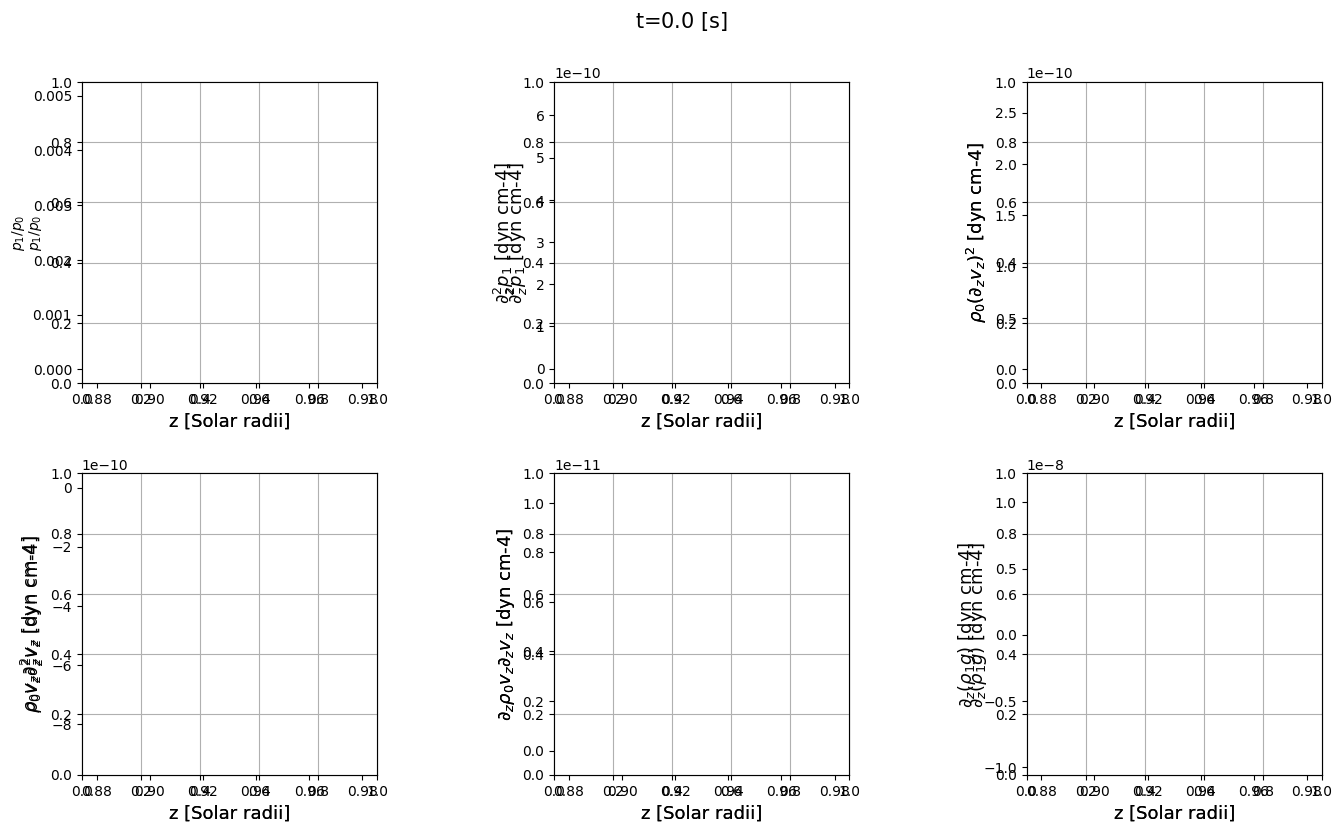

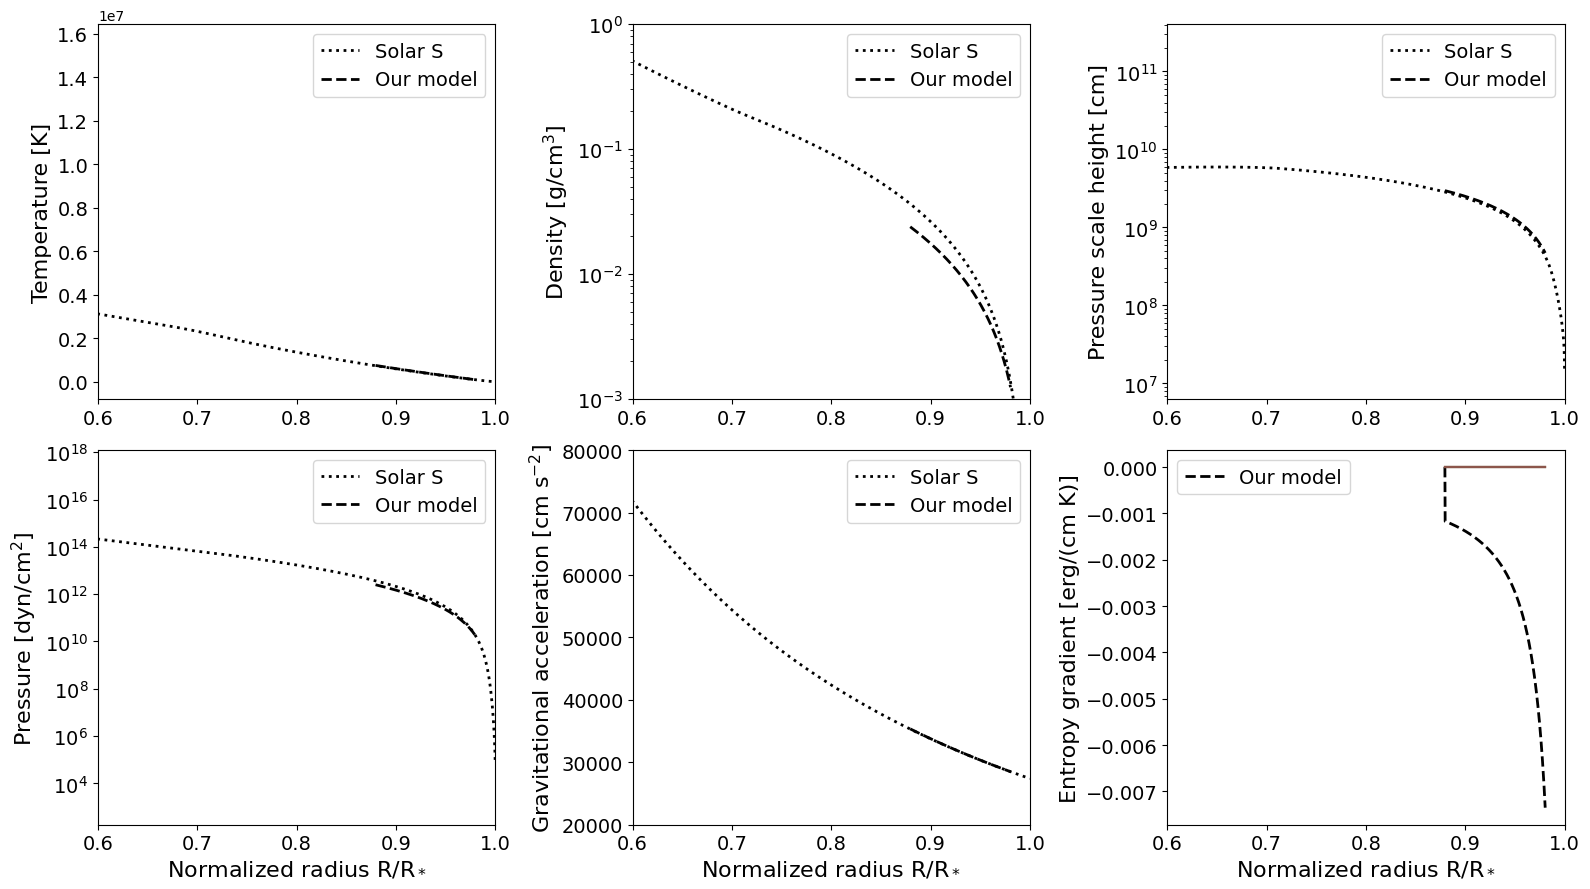

In [25]:
RUN_NAME = "p1_zero_no_soft_wall/"
SAVE_FOLDER = 'data/'

if not os.path.exists(SAVE_FOLDER+RUN_NAME):
    os.makedirs(SAVE_FOLDER+RUN_NAME)


kwargs = {
'normalize':True,
'plot_order':['vz','rhs_vz', 'dp1_dz_over_rho0', 'rho1_g_over_rho0', 'vz_dvz_dz', 'p1'],
'custom_plots':{
    'rhs_vz':plot_rhs_vz_1D, 'dp1_dz_over_rho0':plot_dp1_dz_over_rho0, 'rho1_g_over_rho0':plot_rho1_g_over_rho0, 'vz_dvz_dz':plot_vz_dvz_dz_upwind,
    },
'normalize':True,
'quiver_on':True,
't_scale':u.s,
}

animate_all_foreground_variables_1D(DATA_FOLDER+RUN_NAME, save=True, save_name=SAVE_FOLDER+RUN_NAME+"vz.mp4", fps=2, save_interval=1, **kwargs)

animate_all_foreground_variables_1D(DATA_FOLDER+RUN_NAME, save=True, save_name=SAVE_FOLDER+RUN_NAME+"foreground.mp4", fps=2, save_interval=1, **{'normalize':True, 't_scale':u.s})

kwargs['plot_order'] = ['p1', 'rhs_p1', 'rho0_dvz_dz_sqrd', 'rho0_vz_ddvz_dzdz', 'vz_dvz_dz_drho0_dz', 'drho1g_dz']
kwargs['custom_plots'] = {'rhs_p1':plot_rhs_p1, 'rho0_dvz_dz_sqrd':plot_rho0_dvz_dz_sqrd, 'rho0_vz_ddvz_dzdz':plot_rho0_vz_ddvz_dzdz, 'vz_dvz_dz_drho0_dz':plot_vz_dvz_dz_drho0_dz, 'drho1g_dz':plot_drho1g_dz}

animate_all_foreground_variables_1D(DATA_FOLDER+RUN_NAME, save=True, save_name=SAVE_FOLDER+RUN_NAME+"p1.mp4", fps=2, save_interval=1, **kwargs)

plot_background(DATA_FOLDER,RUN_NAME, SAVE_FOLDER+RUN_NAME+"background.png")

#fig = plt.figure(figsize=(16,9))

#plot_all_foreground_variables_1D(DATA_FOLDER+RUN_NAME, fig, 0, **kwargs)

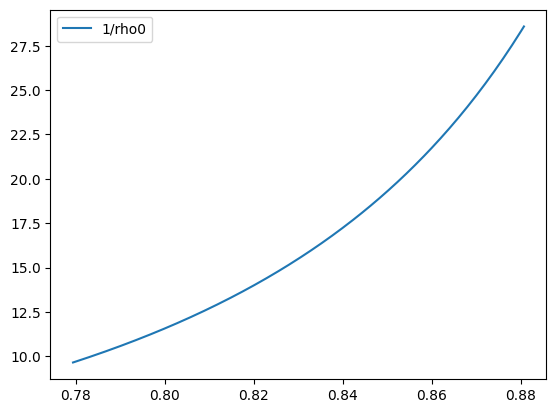

In [95]:
rho0 = get_background_variable(DATA_FOLDER+RUN_NAME, 'rho0')[0]
r = get_background_variable(DATA_FOLDER+RUN_NAME, 'r')[0]
plt.plot(r/R_SUN, 1/rho0, label='1/rho0')
plt.legend()